In [1]:
# NFQ

In [2]:
!nvidia-smi

Sun Feb 17 16:41:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.18       Driver Version: 415.18       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:0B:00.0 Off |                  N/A |
| 23%   37C    P8    17W / 250W |   1134MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:41:00.0  On |                  N/A |
| 36%   62C    P0    62W / 250W |    664MiB / 12188MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import time
import json
import sys
import gym
import io
import os

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 20
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')

%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rc('font', size=24)
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)

np.set_printoptions(suppress=True)

In [4]:
torch.cuda.is_available()

True

In [5]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, seed=None, unwrapped=False, 
                    monitor_mode=None, addon_wrappers=None):
        mdir = tempfile.mkdtemp()
        env = gym.make(env_name)
        if seed is not None: env.seed(seed)
        env = env.unwrapped if unwrapped else env
        env = wrappers.Monitor(
            env, mdir, force=True, mode=monitor_mode) if monitor_mode else env
        if addon_wrappers:
            for wrapper in addon_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [6]:
def plot_results(results, log_scale=False):
    plt.figure(figsize=(15, 10))
    lines = ["-","--",":","-."]
    linecycler = cycle(lines)
    for experiment, experiment_name, env in results:
        label = '\n'.join(wrap(experiment_name.replace('_', ', '), 50))
        plt.plot(experiment, next(linecycler), label=label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if log_scale: plt.xscale('log')
    plt.ylabel('Rewards')
    plt.xlabel('Episode')
    plt.show()

In [7]:
def get_videos_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [8]:
def get_gif_html(env_videos, title, max_n_videos=5):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [9]:
class DiscountedCartPole(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    def step(self, a):
        o, r, d, _ = self.env.step(a)
        (x, x_dot, theta, theta_dot) = o
        pole_fell =  x < -self.env.unwrapped.x_threshold \
                    or x > self.env.unwrapped.x_threshold \
                    or theta < -self.env.unwrapped.theta_threshold_radians \
                    or theta > self.env.unwrapped.theta_threshold_radians
        r = -1 if pole_fell else 0
        return o, r, d, _

# NFQ

In [10]:
class FCQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, 
                                     hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(
                hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(
            hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [11]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)

In [12]:
class EGreedyStrategy():
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

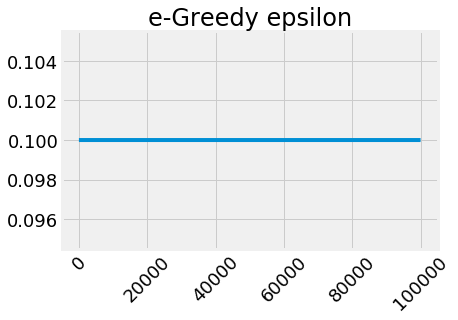

In [13]:
s = EGreedyStrategy()
plt.plot([s.epsilon for _ in range(100000)])
plt.title('e-Greedy epsilon')
plt.xticks(rotation=45)
plt.show()

In [14]:
class NFQ():
    def __init__(self, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 batch_size,
                 epochs):
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.batch_size = batch_size
        self.epochs = epochs

    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences
        batch_size = len(is_terminals)
        
        max_a_q_sp = self.online_model(next_states).detach().max(1)[0].unsqueeze(1)
        target_q_s = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)
        q_sa = self.online_model(states).gather(1, actions)

        td_errors = q_sa - target_q_s
        value_loss = td_errors.pow(2).mul(0.5).mean()
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

    def interaction_step(self, state, env):
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, _ = env.step(action)
        past_limit_enforced = hasattr(env, '_past_limit') and env._past_limit()
        is_failure = is_terminal and not past_limit_enforced

        experience = (state, action, reward, new_state, float(is_failure))
        self.experiences.append(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
        return new_state, is_terminal

    def train(self, make_env_fn, make_env_kargs, seed, gamma, 
              max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma
        
        env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
        torch.manual_seed(self.seed) ; np.random.seed(self.seed) ; random.seed(self.seed)
    
        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []        
        self.episode_exploration = []
        
        self.online_model = self.value_model_fn(nS, nA)
        self.value_optimizer = self.value_optimizer_fn(self.online_model, 
                                                       self.value_optimizer_lr)

        self.training_strategy = training_strategy_fn()
        self.evaluation_strategy = evaluation_strategy_fn() 
        self.experiences = []

        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()
            
            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)
                
                if len(self.experiences) >= self.batch_size:
                    experiences = np.array(self.experiences)
                    batches = [np.vstack(sars) for sars in experiences.T]
                    experiences = self.online_model.load(batches)
                    for _ in range(self.epochs):
                        self.optimize_model(experiences)
                    self.experiences.clear()
                
                if is_terminal:
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward
            elapsed_str = time.strftime("%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
                
        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        return result, final_eval_score, training_time, wallclock_time
    
    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)
            for _ in count():
                a = self.evaluation_strategy.select_action(self.online_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        return np.mean(rs), np.std(rs)
    
    def demo(self, title='Trained {} Agent', n_episodes=10, max_n_videos=3):          
        env = self.make_env_fn(**self.make_env_kargs, monitor_mode='evaluation')
        self.evaluate(self.online_model, env, n_episodes=n_episodes)
        env.close()
        data = get_gif_html(env_videos=env.videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        del env
        return HTML(data=data)

In [15]:
nfq_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in [12, 34, 56, 78, 90]:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    # value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
    # evaluation_strategy_fn = lambda: EGreedyStrategy(epsilon=0.05)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    batch_size = 1024
    epochs = 40

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = NFQ(value_model_fn, 
                value_optimizer_fn, 
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                batch_size,
                epochs)

    # make_env_fn, make_env_kargs = get_make_env_fn(
    #     env_name=env_name, addon_wrappers=[DiscountedCartPole,])
    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    nfq_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
nfq_results = np.array(nfq_results)
_ = BEEP()

el 00:02, ep 0000, ts 000015, ar 10 015.0±000.0, 100 015.0±000.0, ex 100 0.3±0.0, ev 009.0±000.0
el 00:22, ep 0869, ts 025680, ar 10 044.0±021.7, 100 041.6±021.4, ex 100 0.2±0.1, ev 052.9±029.7
el 00:42, ep 1026, ts 043540, ar 10 162.9±067.1, 100 120.1±072.3, ex 100 0.3±0.1, ev 252.4±096.3
el 01:02, ep 1144, ts 060416, ar 10 101.1±057.8, 100 142.1±090.0, ex 100 0.3±0.1, ev 314.5±121.8
el 01:22, ep 1265, ts 077399, ar 10 113.1±057.0, 100 133.9±085.2, ex 100 0.3±0.0, ev 303.7±120.8
el 01:42, ep 1384, ts 092841, ar 10 114.9±067.7, 100 129.6±083.5, ex 100 0.3±0.1, ev 361.2±115.9
el 02:02, ep 1483, ts 109671, ar 10 144.5±077.6, 100 168.6±103.1, ex 100 0.3±0.1, ev 399.2±109.9
el 02:22, ep 1602, ts 126982, ar 10 191.0±105.2, 100 136.2±089.6, ex 100 0.3±0.1, ev 296.9±116.3
el 02:42, ep 1696, ts 144059, ar 10 159.7±102.8, 100 180.5±113.7, ex 100 0.3±0.0, ev 423.6±092.3
el 03:02, ep 1786, ts 159920, ar 10 199.6±141.8, 100 174.6±114.4, ex 100 0.3±0.1, ev 440.7±069.5
el 03:22, ep 1884, ts 176280, 

el 00:20, ep 0716, ts 022078, ar 10 086.7±044.4, 100 061.2±043.1, ex 100 0.3±0.1, ev 149.0±139.0
el 00:40, ep 1032, ts 040333, ar 10 078.2±059.7, 100 103.1±057.2, ex 100 0.3±0.1, ev 200.9±093.2
el 01:00, ep 1225, ts 057259, ar 10 134.9±087.1, 100 047.0±057.4, ex 100 0.3±0.1, ev 086.8±102.4
el 01:20, ep 1332, ts 074243, ar 10 130.0±095.1, 100 151.3±102.9, ex 100 0.3±0.1, ev 381.3±089.4
el 01:40, ep 1444, ts 092016, ar 10 158.3±118.5, 100 160.6±103.8, ex 100 0.3±0.1, ev 357.6±124.9
el 02:00, ep 1549, ts 107787, ar 10 184.6±134.1, 100 149.4±116.9, ex 100 0.3±0.1, ev 356.5±134.5
el 02:20, ep 1681, ts 123261, ar 10 105.7±096.1, 100 120.4±099.0, ex 100 0.3±0.1, ev 360.6±140.3
el 02:40, ep 1800, ts 141951, ar 10 152.8±115.1, 100 159.6±102.7, ex 100 0.3±0.1, ev 386.1±095.6
el 03:00, ep 1908, ts 156654, ar 10 113.1±073.8, 100 132.2±101.6, ex 100 0.3±0.1, ev 356.5±125.4
el 03:21, ep 1999, ts 172035, ar 10 178.2±131.1, 100 164.9±112.9, ex 100 0.3±0.1, ev 430.5±089.6
el 03:41, ep 2094, ts 187643, 


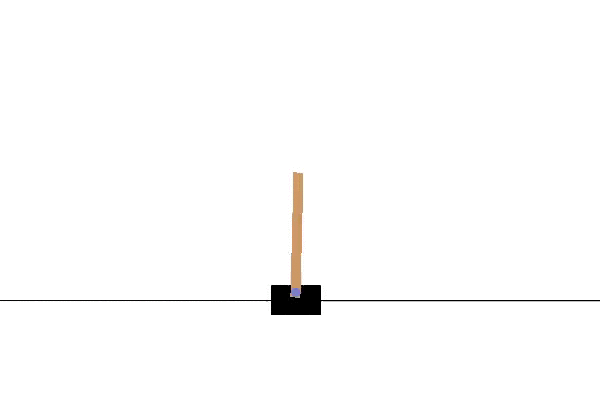
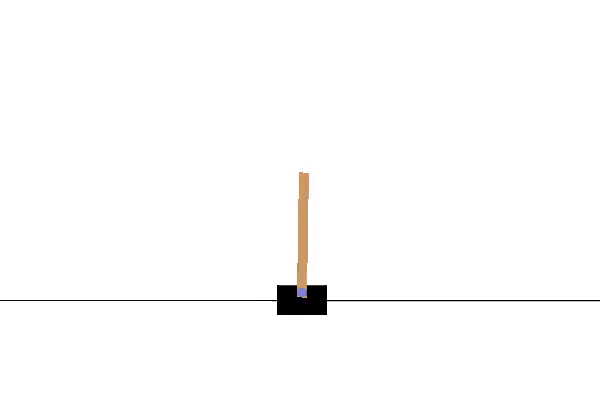
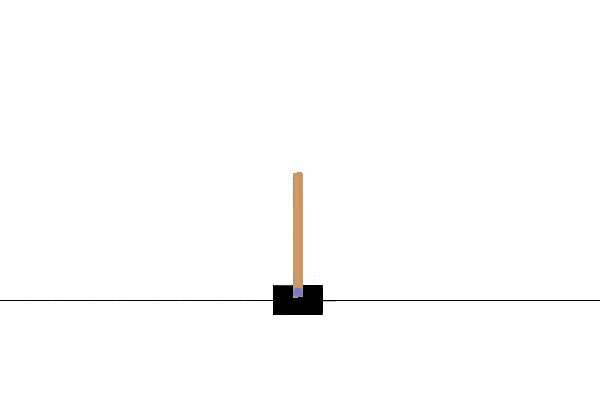

In [16]:
best_agent.demo()

In [17]:
nfq_max_t, nfq_max_r, nfq_max_s, \
    nfq_max_sec, nfq_max_rt = np.max(nfq_results, axis=0).T
nfq_min_t, nfq_min_r, nfq_min_s, \
    nfq_min_sec, nfq_min_rt = np.min(nfq_results, axis=0).T
nfq_mean_t, nfq_mean_r, nfq_mean_s, \
    nfq_mean_sec, nfq_mean_rt = np.mean(nfq_results, axis=0).T
nfq_x = np.arange(len(nfq_mean_s))

# nfq_max_t, nfq_max_r, nfq_max_s, \
#     nfq_max_sec, nfq_max_rt = np.nanmax(nfq_results, axis=0).T
# nfq_min_t, nfq_min_r, nfq_min_s, \
#     nfq_min_sec, nfq_min_rt = np.nanmin(nfq_results, axis=0).T
# nfq_mean_t, nfq_mean_r, nfq_mean_s, \
#     nfq_mean_sec, nfq_mean_rt = np.nanmean(nfq_results, axis=0).T
# nfq_x = np.arange(len(nfq_mean_s))

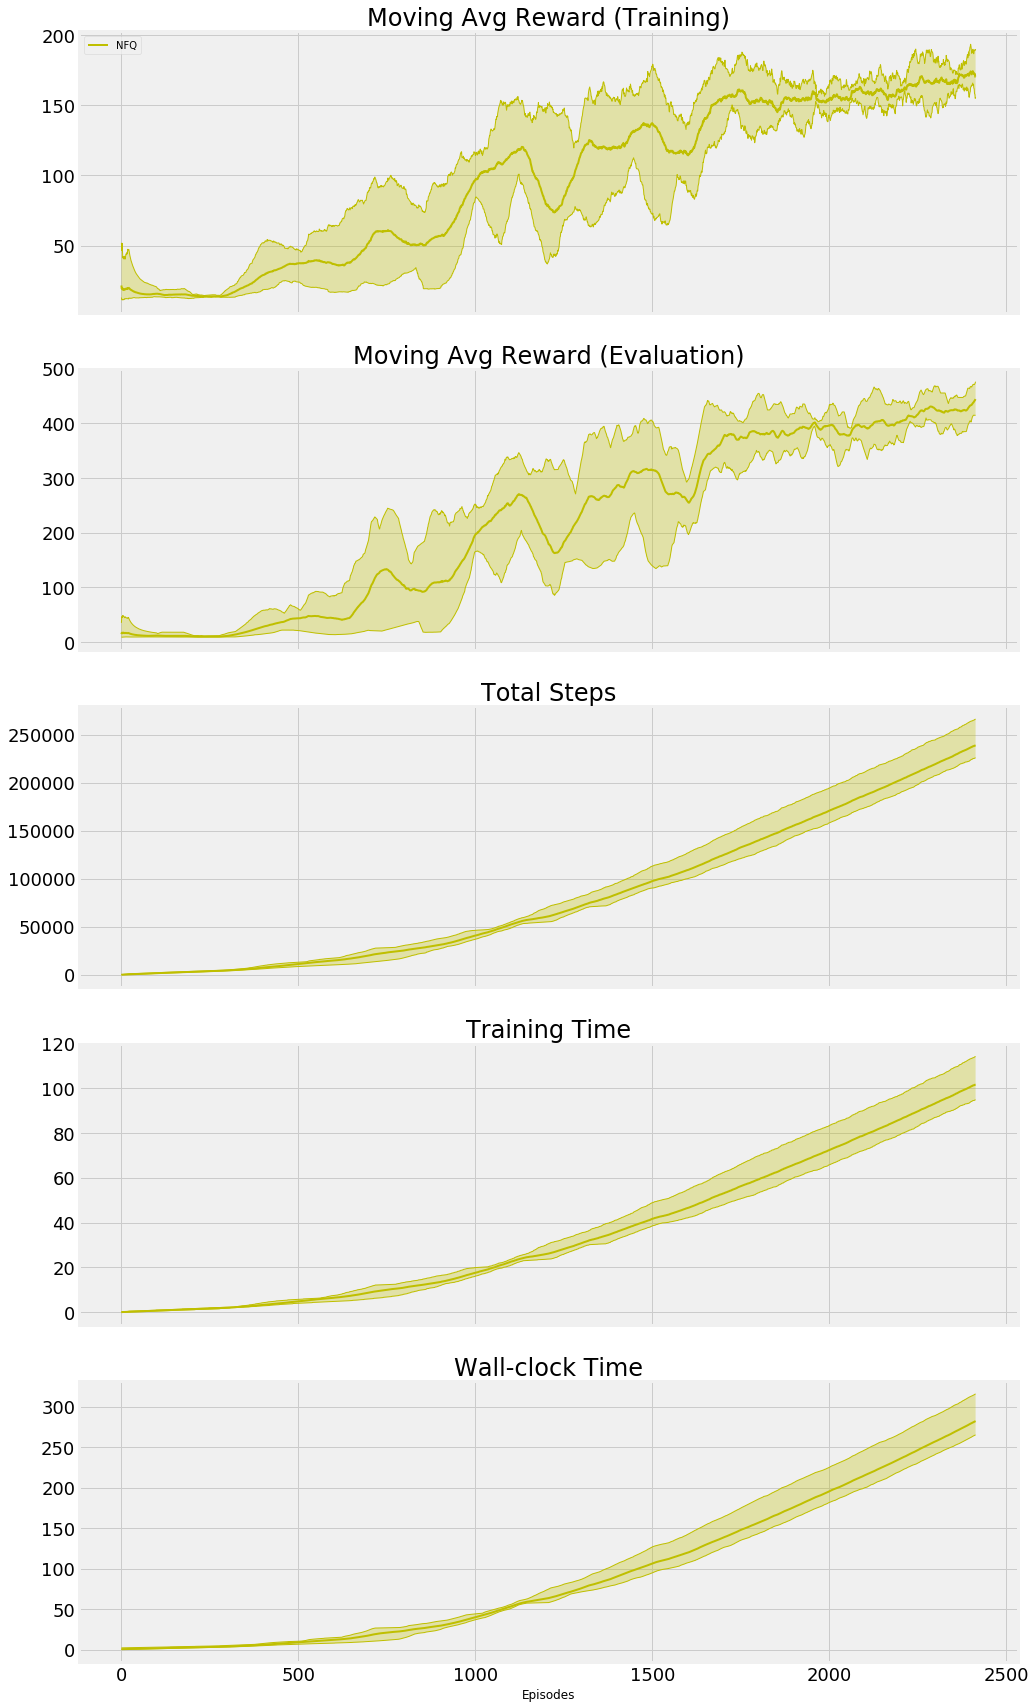

In [18]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [19]:
nfq_root_dir = os.path.join(RESULTS_DIR, 'nfq')
not os.path.exists(nfq_root_dir) and os.makedirs(nfq_root_dir)

np.save(os.path.join(nfq_root_dir, 'x'), nfq_x)

np.save(os.path.join(nfq_root_dir, 'max_r'), nfq_max_r)
np.save(os.path.join(nfq_root_dir, 'min_r'), nfq_min_r)
np.save(os.path.join(nfq_root_dir, 'mean_r'), nfq_mean_r)

np.save(os.path.join(nfq_root_dir, 'max_s'), nfq_max_s)
np.save(os.path.join(nfq_root_dir, 'min_s'), nfq_min_s )
np.save(os.path.join(nfq_root_dir, 'mean_s'), nfq_mean_s)

np.save(os.path.join(nfq_root_dir, 'max_t'), nfq_max_t)
np.save(os.path.join(nfq_root_dir, 'min_t'), nfq_min_t)
np.save(os.path.join(nfq_root_dir, 'mean_t'), nfq_mean_t)

np.save(os.path.join(nfq_root_dir, 'max_sec'), nfq_max_sec)
np.save(os.path.join(nfq_root_dir, 'min_sec'), nfq_min_sec)
np.save(os.path.join(nfq_root_dir, 'mean_sec'), nfq_mean_sec)

np.save(os.path.join(nfq_root_dir, 'max_rt'), nfq_max_rt)
np.save(os.path.join(nfq_root_dir, 'min_rt'), nfq_min_rt)
np.save(os.path.join(nfq_root_dir, 'mean_rt'), nfq_mean_rt)